In [23]:
import json, datetime, time, os
from glob import glob
import pylab as pl
import numpy as np

DATA_ROOT = "irb"

def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
        print("File not found", prefix, 'in', folder)
        return None
    else: 
        with open(files[0], 'r') as f: 
            contents = json.load(f)
            return contents, files[0]
        
def adjust_data(folder, data, t, Fs):
    metadata,f = get_file(folder, "sessionmetadata")

    # ADJUST Y AND T RANGE    
    start = metadata["session_start"] - t
    end = metadata["session_end"] - t    
    t0 = start * Fs 
    t0 = start * Fs  if start > 0 else 0
    tf = end * Fs - 1 if end < len(data) else len(data)
    t0 = int(t0)
    tf = int(tf)
    data = data[t0:tf]
    return data

def save_jsonfile(name, data):
    with open(name, 'w') as outfile:
        json.dump(data, outfile)
    print("File saved!", name)
    


In [24]:
def constructMTS(users, features):     
    tsum = 0
    umts = {}
    for user in users: 
        mts = []
        umts[user] = mts
#         print('Constructing MTS on', user)
        folder = os.path.join(DATA_ROOT, str(user))
        for feature in features: 
            contents, f = get_file(folder, feature)
            data = contents["data"]
           
            t = contents["timestamp"]
            F = contents["sampling_rate"]
            data = adjust_data(folder, data, t, F)
#             print('Compiling', feature, len(data))
            mts.append(data)
            tsum = tsum + len(data)
    for u in umts:
        mts = umts[u]
        max_t = len(max(mts, key=lambda f: len(f)))
        fmts = np.zeros((len(mts), max_t))
        print('mts_shape', u, fmts.shape)
        for i, f in enumerate(mts):
#             print(f)
            fmts[i, :] = f
        umts[u] = fmts
    return umts, tsum

In [39]:
'''
mts is in the dictionary structured as
user: features x t

subsequence routine extracts all L windows with a L/2 overlap
'''
def subsequences(a, L):
    n, m = a.shape
    windows = int(m/L)    
    window_range = np.linspace(0, windows-1, (windows-1) * 2 + 1)
    ss = []
    for x in window_range:
        ss.append(a[:, int(x*L):int((x+1)*L)])
    return np.array(ss)

def subsequenceMTS(umts, L):
    sss = np.array([])
    bounds = [0]
    for u in umts: 
        mts = umts[u]
        ss = subsequences(mts, L)
        print("SS", u, ss.shape)
        bounds.append(bounds[-1] + ss.shape[0])
        if sss.shape[0] == 0:
            sss = ss
        else:
            sss = np.concatenate((sss, ss))
    word_shape = sss.shape[-2:]
    sss = sss.reshape(sss.shape[0], -1)
    return sss, bounds, word_shape
        

# MATRIX CREATION 

In [43]:
pl.rcParams['figure.figsize'] = [18, 10]

users = [411, 113]

L = 100
features = ["acc-x", "acc-y", "acc-z"]

mts, tsum = constructMTS(users, features)
sss, bounds, word_shape = subsequenceMTS(mts, L)

print(sss.shape, bounds)

meta = {
    "L": L,
    "bounds": bounds,
    "word_shape": word_shape,
    "description": "Accelerometer data for 2 users.",
    "users": users, 
    "features": features, 
    "subsequences": sss.tolist()
}

mts_shape 411 (3, 42125)
mts_shape 113 (3, 36104)
SS 411 (841, 3, 100)
SS 113 (721, 3, 100)
(1562, 300) [0, 841, 1562]


In [44]:
save_jsonfile(os.path.join("irb/datasets", "acc_for_2.json"), meta)

File saved! irb/datasets/acc_for_2.json


# Visualize MTS Matrix

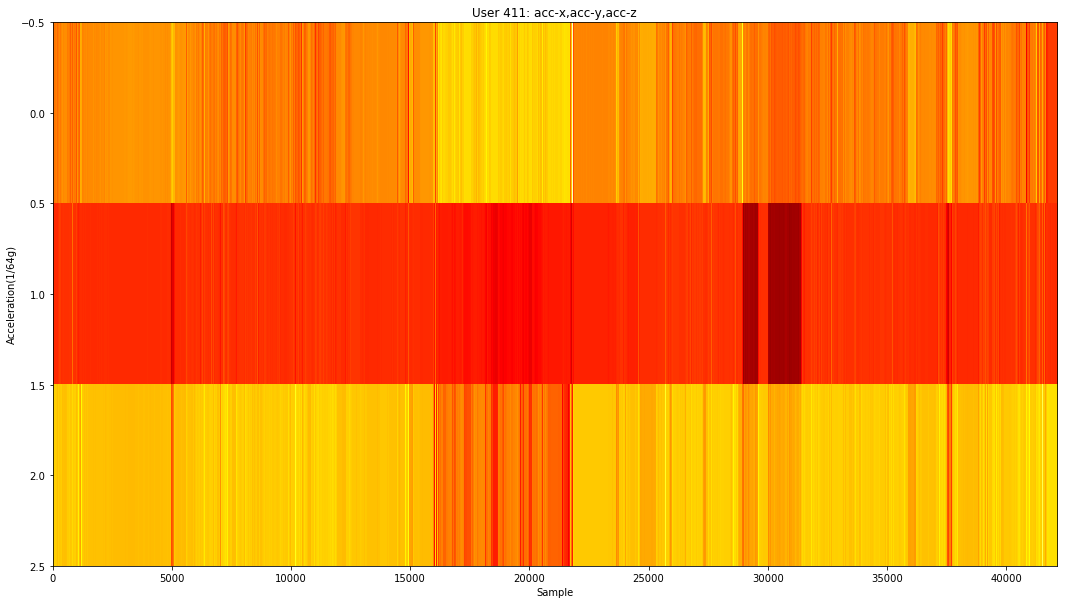

In [42]:
user = users[0]
pl.imshow(mts[user], cmap='hot', interpolation='nearest', aspect='auto')
pl.title("User %i: %s" % (user, ",".join(features)))
pl.ylabel("Acceleration(1/64g)")
pl.xlabel("Sample")
pl.show()